# Машинное обучение 1, ПМИ ФКН ВШЭ
# Семинар 9
# Решающие деревья

На этом семинаре разберем *решающие деревья* - интуитивный и интерпретируемый алгоритм, способный моделировать нелинейные зависимости и служащий базой для ансамблей. На примерах посмотрим, как дерево строит пороговые разбиения "если-то", визуализируем структуру узлов и границы решений, сравним критерии качества (MSE, Джини, энтропия) и увидим, как гиперпараметры (`max_depth`, `min_samples_leaf`, `criterion`) влияют на переобучение и итоговую точность. Работать будем опять с `scikit-learn`, чередуя короткую теорию с кодом и разбором результатов.



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris, load_wine, make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

## Принцип работы решающих деревьев

Решающие деревья $-$ один из алгоритмов машинного обучения, позволяющий восстанавливать нелинейные зависимости любой сложности. Они интуитивно понятны, легко интерпретируемы и, несмотря на склонность к переобучению, часто  используются как основа для более сложных алгоритмов. Принцип работы решающих деревьев очень прост: каждая вершина представляет собой условие вида «если признак $x_i$ не больше выбранного порога». В зависимости от того, верно ли условие, алгоритм переходит в левое или правое поддерево, пока не достигает листьев, которые содержат предсказания модели. Такой метод позволяет легко визуализировать процесс принятия решения и интерпретировать результат.

Для лучшего понимания того, как работают решающие деревья, рассмотрим задачу многоклассовой классификации на примере датасета Iris, в котором хранится информация о $150$ ирисах трёх разных видов: ирис щетинистый (Iris setosa), ирис виргинский (Iris virginica) и ирис разноцветный (Iris versicolor). Для каждого объекта известны четыре признака, мы будем использовать два из них: длину лепестка и его ширину.

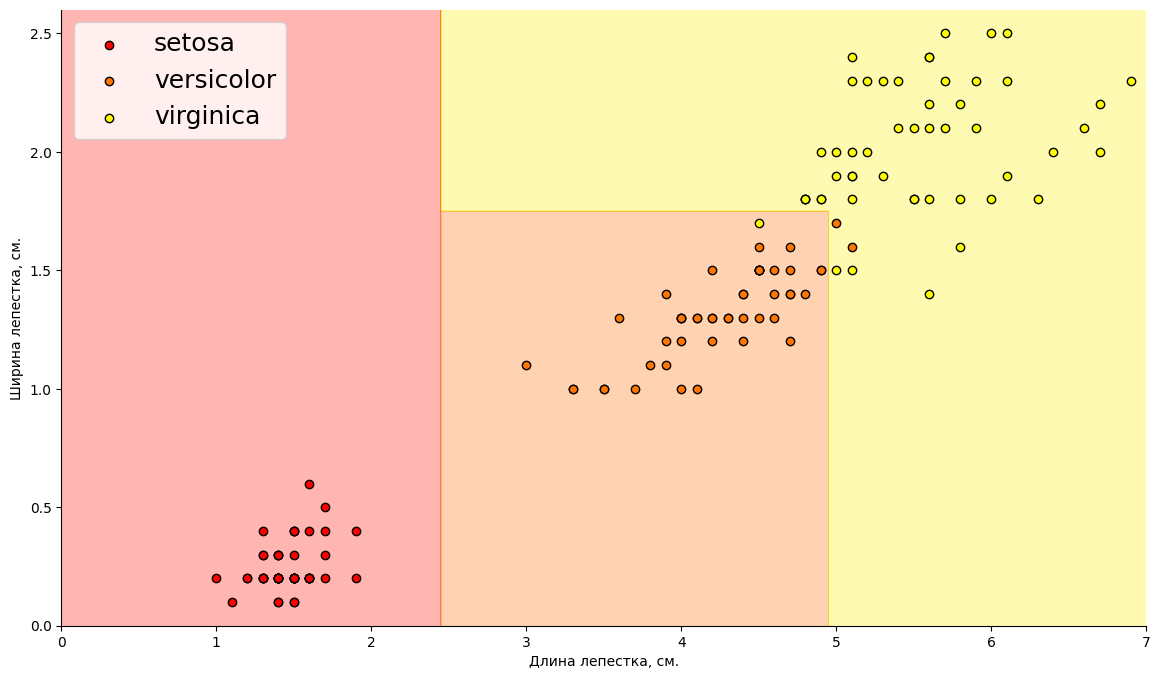

In [ ]:
# загружаем данные, для простоты визуализации работаем только с двумя признаками
data = load_iris()
X = data.data[:, 2:]
y = data.target

# обучаем решающее дерево
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X, y)

# визуализируем результаты
x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                     np.linspace(y_min, y_max, 1000))

z = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(14, 8))
plt.contourf(xx, yy, z, alpha=0.3, cmap=plt.cm.autumn)

colors = ['#FF0000', '#FF7700', '#FFFF00']
for i, color in zip(range(3), colors):
    plt.scatter(X[y == i, 0], X[y == i, 1], c=color, label=data.target_names[i], edgecolor='k')

plt.xlabel("Длина лепестка, см.")
plt.ylabel("Ширина лепестка, см.")
plt.legend(fontsize=18)

for ax in plt.gcf().get_axes():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()

Построенный график демонстрирует, как работает решающее дерево. Модель опирается на два признака, которые мы выбрали. Сначала проверяется длина лепестка: если она меньше $2.5$ сантиметров, то модель относит объект к классу щетинистых ирисов, иначе проверяется ширина лепестка. В том случае, если она больше $1.75$, объект относится к классу виргинских ирисов, иначе $-$ к классу разноцветных ирисов.

Решающее дерево пошагово проверяет условия и предсказывает класс в зависимости от того, в какой лист попадает объект. Алгоритм принятия решения может быть представлен следующей схемой.

![](https://i.postimg.cc/FFj9gGff/iris-schema.png)

## Алгоритм построения решающего дерева

Итак, рассмотрим дерево, в котором каждой вершине $v$ соответствует некоторый предикат $\beta_v: X \to \{0, 1\}$, а каждому листу $-$ прогноз $c_v \in Y$. Формально **бинарное решающее дерево** $-$ это алгоритм на таком дереве, стартующий из корневой вершины $v_0$ и вычисляющий значение функции $\beta_{v_0}$. Если оно равно нулю, то алгоритм переходит в левую дочернюю вершину, иначе $-$ в правую. Затем алгоритм вычисляет значение предиката в новой вершине и делает очередной переход; процесс продолжается, пока не будет достигнута листовая вершина. В качестве предсказания модели алгоритм возвращает то предсказание, которое приписано этому листу.

Стоит отметить, что предикат может иметь произвольную структуру, однако чаще всего на практике используется сравнение какого-то признака с некоторым порогом.

### Проблема переобучения решающих деревьев ##

Очевидно, что для любой выборки можно обучить решающее дерево так, чтобы оно полностью подстраивалось под имеющиеся данные (для этого достаточно, чтобы каждый объект попадал в свой лист). Однако такой подход не позволит получить высокое качество на новых данных. Наглядно продемонстрируем это с помощью задачи многоклассовой классификации на примере другого датасета - Wine, объекты которого не так однозначно отделимы друг от друга.

Точность дерева, построенного с заданным ограничением на глубину: 0.8055555555555556
Точность дерева, построенного без ограничения на глубину: 0.7222222222222222


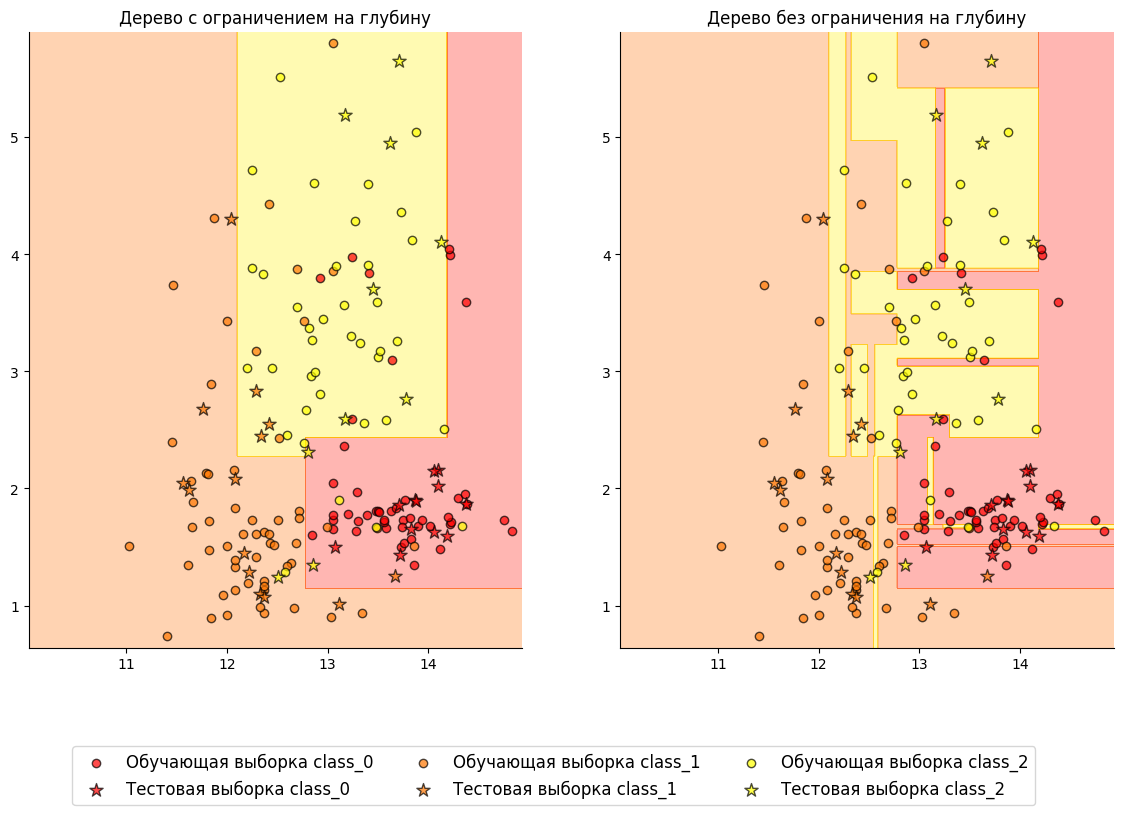

In [ ]:
# загружаем данные, для простоты визуализации работаем только с двумя признаками
data = load_wine()
X = data.data[:, :2]
y = data.target

# для оценки качества разбиваем датасет на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# обучим два дерева: первое будет иметь ограничение на глубину, второе - нет
tree_with_limits = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_with_limits.fit(X_train, y_train)
tree_without_limits = DecisionTreeClassifier(max_depth=None, random_state=42)
tree_without_limits.fit(X_train, y_train)

# получим предсказания для тестовой выборки для обеих моделей и посчитаем accuracy
y_predicted_with_limits = tree_with_limits.predict(X_test)
accuracy_with_limits = accuracy_score(y_test, y_predicted_with_limits)
y_predicted_without_limits = tree_without_limits.predict(X_test)
accuracy_without_limits = accuracy_score(y_test, y_predicted_without_limits)

print("Точность дерева, построенного с заданным ограничением на глубину:", accuracy_with_limits)
print("Точность дерева, построенного без ограничения на глубину:", accuracy_without_limits)

colors = ['#FF0000', '#FF7700', '#FFFF00']

# визуализируем результаты
x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                     np.linspace(y_min, y_max, 1000))

z_with_limits = tree_with_limits.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
z_without_limits = tree_without_limits.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

fig, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].contourf(xx, yy, z_with_limits, alpha=0.3, cmap=plt.cm.autumn)
ax[0].set_title("Дерево с ограничением на глубину")
for i, color in zip(range(3), colors):
    ax[0].scatter(X_train[np.where(y_train == i), 0], X_train[np.where(y_train == i), 1], c=color, edgecolor='k', marker='o', alpha=0.7)
    ax[0].scatter(X_test[np.where(y_test == i), 0], X_test[np.where(y_test == i), 1], c=color, edgecolor='k', marker='*', s=100, alpha=0.7)

ax[1].contourf(xx, yy, z_without_limits, alpha=0.3, cmap=plt.cm.autumn)
ax[1].set_title("Дерево без ограничения на глубину")
for i, color in zip(range(3), colors):
    ax[1].scatter(X_train[np.where(y_train == i), 0], X_train[np.where(y_train == i), 1], c=color, edgecolor='k', marker='o', label=f'Обучающая выборка {data.target_names[i]}', alpha=0.7)
    ax[1].scatter(X_test[np.where(y_test == i), 0], X_test[np.where(y_test == i), 1], c=color, edgecolor='k', marker='*', s=100, label=f'Тестовая выборка {data.target_names[i]}', alpha=0.7)

fig.legend(fontsize=12, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=3)

for ax_ in ax:
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)

plt.show()

О переобучении свидетельствует как вычисленное значение accuracy ($≈0.805$ против $≈0.722$), так и построенные графики. Дерево с ограничением на глубину (max_depth $= 3$) не идеально предсказывает классы для объектов из обучающей выборки, однако успешно улавливает общие тенденции, благодаря чему алгоритм допускает ошибки в предсказаниях только для тех объектов тестовой выборки, которые по своим признакам очень похожи на объекты других классов из обучающей выборки. В то же время дерево, не имеющее ограничений на глубину, идеально подстраивается под обучающую выборку, разделяя пространство на отдельные области для каждого объекта, что приводит к значительному числу неверных предсказаний для тестовой выборки.

В идеале для того, чтобы избежать переобучения, при построении дерева необходимо среди всех возможных деревьев выбирать то, которое имеет наименьшую глубину и нулевую ошибку на обучающей выборке. Эта задача, впрочем, является NP-полной, поэтому на практике обычно ограничиваются жадным алгоритмом построения решающего дерева.

### Жадный алгоритм построения решающего дерева ##

Пусть дана обучающая выборка $X$, найдём лучшее её разбиение с точки зрения заранее заданного функционала качества $Q(X, j, t)$ на две части: $R_1(j, t) = \{x | x_j < t\}$ и $R_2(j, t) = \{x | x_j \geq t\}$. После нахождения оптимальных значений $j$ и $t$ создадим корневую вершину дерева и поставим ей в соответствие предикат $[x_j < t]$. Все объекты разобьются на две части: часть из них попадёт в левое поддерево, остальные $-$ в правое. Для каждой из этих подвыборок рекурсивно повторим процедуру. На каждом шаге для очередной вершины необходимо проверить, не выполнилось ли некоторое условие останова: если да, то вершина становится листом и рекурсия прекращается. Когда дерево построено, каждому листу ставится в соответствие ответ.

Таким образом, для применения жадного алгоритма необходимо выбрать функционал качества, определить используемое условие останова и способ вычисления предсказания, соответствующего каждому листу. Обсудим, как их можно подобрать.

### Предсказания в листовых вершинах ##

Способ получения предсказания модели, которое ставится в соответствие каждому листу, зависит от решаемой задачи. Например, в случае задачи регрессии чаще всего используется некоторая статистика (обычно среднее или медиана) или простая модель. В частности, листы в дереве, полученном при решении задачи регрессии, могут быть линейными функциями, которые обучены на тех объектах, которые попадают в лист. Когда решается задача классификации, ответ в листовой вершине обычно соответствует классу, к которому чаще всего относятся объекты, попавшие в неё. Иногда также в качестве предсказания используется оценка дискретного распределения вероятностей классов для всех объектов из листа.

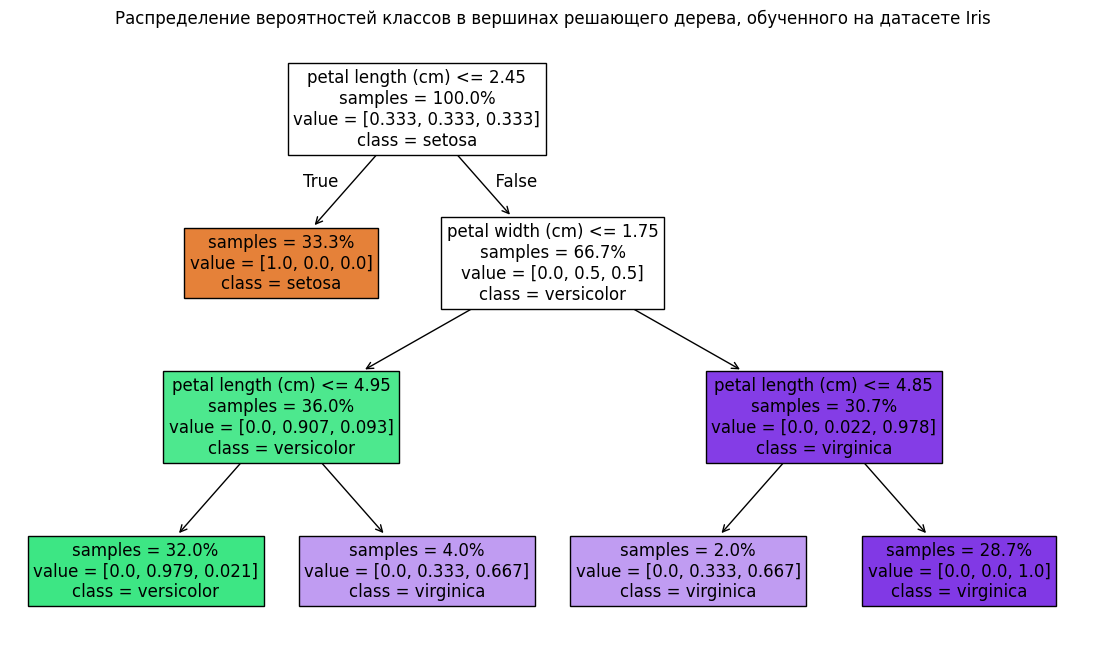

In [ ]:
# загружаем данные, с которыми работали ранее - датасет ирисов
data = load_iris()
X = data.data
y = data.target
feature_names = data.feature_names
class_names = data.target_names

# обучаем решающее дерево
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X, y)

plt.figure(figsize=(14, 8))
plot_tree(
    tree,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    fontsize=12,
    impurity=False,
    proportion=True # отобразим, каковы доли объектов каждого из классов в очередной вершине
)

plt.title("Распределение вероятностей классов в вершинах решающего дерева, обученного на датасете Iris")
plt.show()

Таким образом, в листовую вершину попадают все объекты, которые удовлетворяют определённой последовательности условий на пути от корня. Предсказание в листе в данной задаче зависит от класса, к которому относится большинство объектов, попавших в него.

## Функционал качества

Особый интерес представляет функционал качества, на основании которого осуществляется разбиение выборки на очередном шаге. Введём следующие обозначения:
* $R_m -$ множество объектов, попавших в вершину, которая разбивается на текущем шаге
* $R_\ell -$ объекты, которые попадают в левое поддерево при заданном предикате
* $R_r -$ объекты, которые попадают в правое поддерево при заданном предикате

Мы будем использовать функционалы следующего вида:
$ Q(R_m, j, s) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r)$, где $H(R) -$ это **критерий информативности**, который позволяет оценить качество распределения целевой переменной среди объектов множества $R$.

Чем меньше разнообразие целевой переменной, тем меньше должно быть значение критерия информативности, соответственно, мы будем пытаться минимизировать его значение. Функционал качества $Q(R_m, j, s)$ мы при этом будем максимизировать.

Будем полагать, что каждому листу дерева соответствует некоторое константное предсказание (вещественное число, вероятность или класс). Тогда качество алгоритма можно оценивать тем, насколько хорошо для множества объектов, попавших в листовую вершину, предсказываются константой соответствующие переменные: $H(R) = \min_{c \in Y} \frac{1}{|R|} \sum_{(x_i, y_i) \in R} L(y_i, c)$, где $L(y, c) -$ некоторая функция потерь.

Обсудим, какие именно критерии информативности обычно используют в задачах регрессии и классификации.

### Функционал качества для задачи регрессии

В качестве функции потерь при решении задачи регрессии выберем квадрат отклонения, тогда критерий информативности будет иметь следующий вид:

$H(R) = \min_{c \in Y} \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2$

Минимум в этом выражении будет достигаться на среднем значении целевой переменной, поэтому критерий можно переписать следующим образом:

$H(R) = \frac{1}{|R|} \sum_{(x_i, y_i) \in R} \left(y_i - \frac{1}{|R|} \sum_{(x_j, y_j) \in R} y_j \right)^2$

Значит, информативность вершины измеряется её дисперсией: чем ниже разброс целевой переменной, тем лучше вершина.

Разумеется, можно использовать и другие функции ошибки $L$: например, при выборе абсолютного отклонения в качестве критерия получится среднее абсолютное отклонение от медианы.

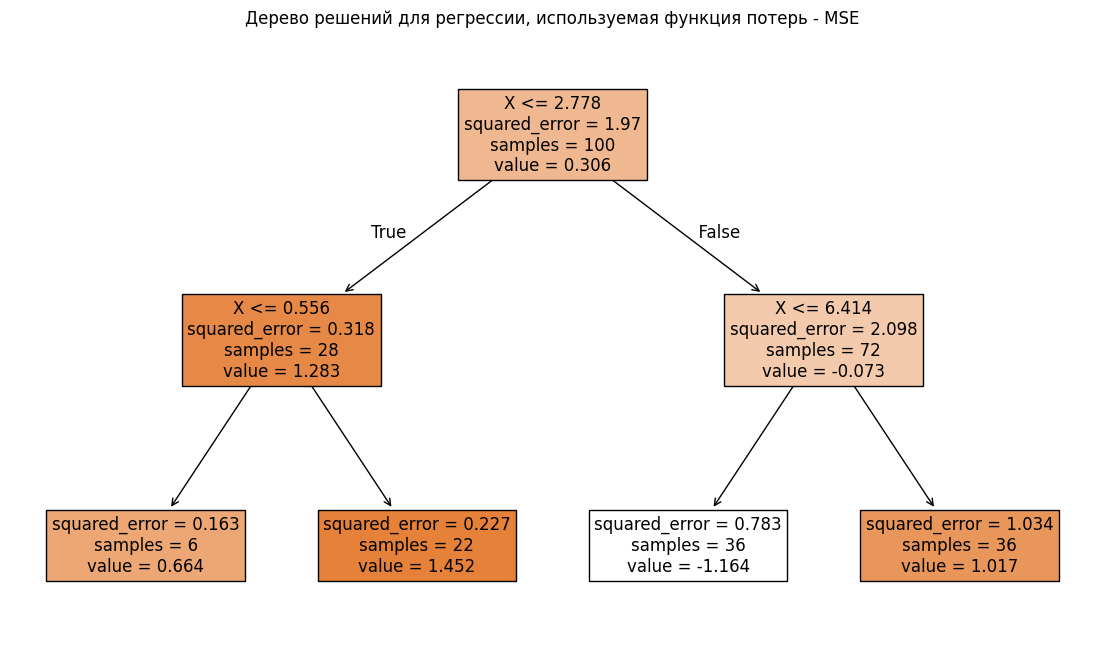

In [ ]:
# сгенерируем синтетические данные
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = 2 * np.sin(X).ravel() + np.random.normal(scale=0.5, size=100)

# обучим дерево небольшой глубины, указав в качестве функции потерь MSE
tree = DecisionTreeRegressor(max_depth=2, criterion="squared_error", random_state=42)
tree.fit(X, y)

plt.figure(figsize=(14, 8))
plot_tree(
    tree,
    feature_names=['X'],
    filled=True,
    fontsize=12
)

plt.title("Дерево решений для регрессии, используемая функция потерь - MSE")
plt.show()

In [ ]:
# выведем информацию о каждой из вершин в обученном дереве
tree_ = tree.tree_
for current_node in range(tree_.node_count):
    n = tree_.n_node_samples[current_node]
    impurity = tree_.impurity[current_node]
    print(f"Всего объектов в вершине: {n}")
    print(f"Критерий информативности: {impurity:.3f}")
    print()

Всего объектов в вершине: 100
Критерий информативности: 1.970

Всего объектов в вершине: 28
Критерий информативности: 0.318

Всего объектов в вершине: 6
Критерий информативности: 0.163

Всего объектов в вершине: 22
Критерий информативности: 0.227

Всего объектов в вершине: 72
Критерий информативности: 2.098

Всего объектов в вершине: 36
Критерий информативности: 0.783

Всего объектов в вершине: 36
Критерий информативности: 1.034



Рассмотрим вершину, в которую попало $6$ объектов и разберёмся, как считать критерий информативности.

In [ ]:
leaves_indices = tree.apply(X)

for current_node in np.unique(leaves_indices):
    objects = np.where(leaves_indices == current_node)[0]
    print("В вершину", current_node, "попали объекты", objects)
    print("Соответствующие значения y равны", np.round(y[objects], 2))
    print()

В вершину 2 попали объекты [0 1 2 3 4 5]
Соответствующие значения y равны [0.25 0.13 0.73 1.36 0.67 0.85]

В вершину 3 попали объекты [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Соответствующие значения y равны [1.93 1.68 1.21 1.85 1.46 1.56 1.99 0.98 1.11 1.72 1.49 2.14 1.49 1.17
 2.53 1.59 1.62 0.75 1.04 1.21 0.41 0.99]

В вершину 5 попали объекты [28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63]
Соответствующие значения y равны [ 0.32  0.28 -0.08  0.95 -0.19 -0.91 -0.17 -1.38 -0.85 -2.1  -1.95 -1.33
 -1.2  -1.6  -1.84 -2.02 -2.67 -2.33 -2.23 -1.47 -1.81 -2.83 -1.72 -2.
 -2.05 -1.3  -0.96 -0.86 -1.59 -1.16 -0.66 -0.15 -0.68 -0.34 -0.59 -0.44]

В вершину 6 попали объекты [64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87
 88 89 90 91 92 93 94 95 96 97 98 99]
Соответствующие значения y равны [ 0.77  1.24  0.71  1.43  1.29  0.95  1.6   2.32  1.65  2.56  0.55  2.33
  2.01  1.84  2.0

Итак, имеем следующие значения целевой переменной в рассматриваемой вершине:
$ y = [0.25, 0.13, 0.73, 1.36, 0.67, 0.85]$, а число элементов, попавших в неё, равно $|R|=6 $

Посчитаем среднее значение целевой переменной:

$\bar{y} = \frac{1}{6}\sum_{i=1}^{6} y_i = \frac{0.25 + 0.13 + 0.73 + 1.36 + 0.67 + 0.85}{6} = \frac{3.99}{6} = 0.665$

Теперь посчитаем квадратичные отклонения:

$(0.25 - 0.665)^2 = 0.172225$

$(0.13 - 0.665)^2 = 0.286225$

$(0.73 - 0.665)^2 = 0.004225$

$(1.36 - 0.665)^2 = 0.483025$

$(0.67 - 0.665)^2 = 0.000025$

$(0.85 - 0.665)^2 = 0.034225$

Тогда сумма квадратичных отклонений равна $\sum_{i=1}^6 (y_i - \bar{y})^2 = 0.97995$

Наконец, посчитаем критерий информативности MSE:

$H(R) = \frac{1}{6} \cdot 0.97995 = 0.163325 ≈ 0.163$

### Ошибка классификации ###

Перейдём к решению задачи классификации.

Пусть $p_k -$ доля объектов класса $k$, попавших в вершину $R$: $p_{k} = \frac{1}{|R|} \sum_{(x_i, y_i) \in R} [y_i = k]$. Через $k_*$ обозначим тот класс, чьих представителей оказалось больше всего среди объектов, попавших в данную вершину.

Рассмотрим в качестве функции потерь индикатор ошибки:

$H(R) = \min_{c \in Y} \frac{1}{|R|} \sum_{(x_i, y_i) \in R}  [y_i \neq c]$

Нетрудно заметить, что оптимальным предсказанием будет самый популярный класс $k_*$, а, значит, критерий будет равен следующей доле ошибок:

$H(R) = \frac{1}{|R|} \sum_{(x_i, y_i) \in R} [y_i \neq k_*] = 1 - p_{k_*}$

Данный критерий, который называется ошибкой классификации, является достаточно грубым, поскольку учитывает частоту $p_{k_*}$ только одного класса, что делает его нечувствительным к незначительным улучшениям разбиения. Намного чаще используются критерий Джини и энтропийный критерий, о них мы далее и поговорим.

### Критерий Джини

Предположим, что каждой вершине соответствует не один класс, а распределение $c = (c_1, \dots, c_K)$, $\sum_{k = 1}^{K} c_k = 1$. Понять, насколько такое распределение соответствует реальным меткам классов в выборке, можно с помощью критерия Брайера:

$H(R) = \min_{\sum_k c_k = 1} \frac{1}{|R|} \sum_{(x_i, y_i) \in R} \sum_{k = 1}^{K} (c_k - [y_i = k])^2$

Нетрудно заметить, что в таком случае каждый $c_k$ ищется как оптимальная с точки зрения MSE константа, которая приближает индикаторы попадания объектов выборки в класс $k$. Поэтому оптимальный вектор вероятностей состоит из долей классов $p_k$: $c_* = (p_1, \dots, p_K)$.

Если подставить эти вероятности в исходный критерий информативности
и провести ряд математических преобразований, то получится критерий Джини:

$H(R) = \sum_{k = 1}^{K} p_k (1 - p_k)$

Иногда критерий Джини также записывают в виде $H(R) = \sum_{k \neq k'} p_{k} p_{k'}$. Эта запись, очевидно, эквивалентна определению выше: $\sum_{k \neq k'} p_{k} p_{k'} = \sum_{k = 1}^{K} p_{k} \sum_{k' \neq k} p_{k'} = \sum_{k = 1}^{K} p_{k} (1 - p_{k})$.

Рассмотрим вершину $m$ и объекты $R$, попавшие в неё. Поставим в соответствие вершине $m$ алгоритм $a(x)$, который выбирает класс случайно, причём класс $k$ выбирается с вероятностью $p_{k}$. Покажем, что математическое ожидание частоты ошибок этого алгоритма на объектах из $R_m$ равно индексу Джини:

$E \frac{1}{|R|} \sum_{(x_i, y_i) \in R} [y_i \neq a(x_i)] = \frac{1}{|R|} \sum_{(x_i, y_i) \in R} E [y_i \neq a(x_i)] = \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (1 - p_{y_i}) = \\ = \sum_{k = 1}^{K} \frac{\sum_{(x_i, y_i) \in R} [y_i = k]}{|R|} (1 - p_{k}) = \sum_{k = 1}^{K} p_{k} (1 - p_{k})$

Обсудим теперь, какой смысл имеет максимизация функционала качества, основанного на критерии Джини. Сразу исключим из критерия $H(R_m)$, поскольку данная величина не зависит от $j$ и $s$. Обозначим долю объектов класса $k$ в вершине $m$ через $p_{mk}$.

Преобразуем критерий:
$- \frac{|R_\ell|}{|R_m|} H(R_\ell) - \frac{|R_r|}{|R_m|} H(R_r) = - \frac{1}{|R_m|} \left(|R_\ell| - \sum_{k = 1}^{K} p_{\ell k}^2 |R_\ell| + |R_r| - \sum_{k = 1}^{K} p_{r k}^2 |R_r| \right) =\\ = \frac{1}{|R_m|} \left(\sum_{k = 1}^{K} p_{\ell k}^2 |R_\ell| + \sum_{k = 1}^{K} p_{r k}^2 |R_r| - |R_m| \right) = \{\text{$|R_m|$ не зависит от $j$ и $s$}\} =\\ = \sum_{k = 1}^{K} p_{\ell k}^2 |R_\ell| + \sum_{k = 1}^{K} p_{r k}^2 |R_r|$

Запишем теперь в наших обозначениях число таких пар объектов $(x_i, x_j)$, что оба объекта попадают в одно и то же поддерево и при этом $y_i = y_j$. Число объектов класса $k$, попавших в поддерево $\ell$, равно $p_{\ell k} |R_\ell|$. Соответственно, число пар объектов с одинаковыми метками, попавших в левое поддерево, равно $\sum_{k = 1}^{K} p_{\ell k}^2 |R_\ell|^2$.

Интересующая нас величина равна $\sum_{k = 1}^{K} p_{\ell k}^2 |R_\ell|^2 + \sum_{k = 1}^{K} p_{r k}^2 |R_r|^2$.

Таким образом, максимизацию критерия Джини можно условно
интерпретировать как максимизацию числа пар объектов одного класса,
оказавшихся в одном поддереве.

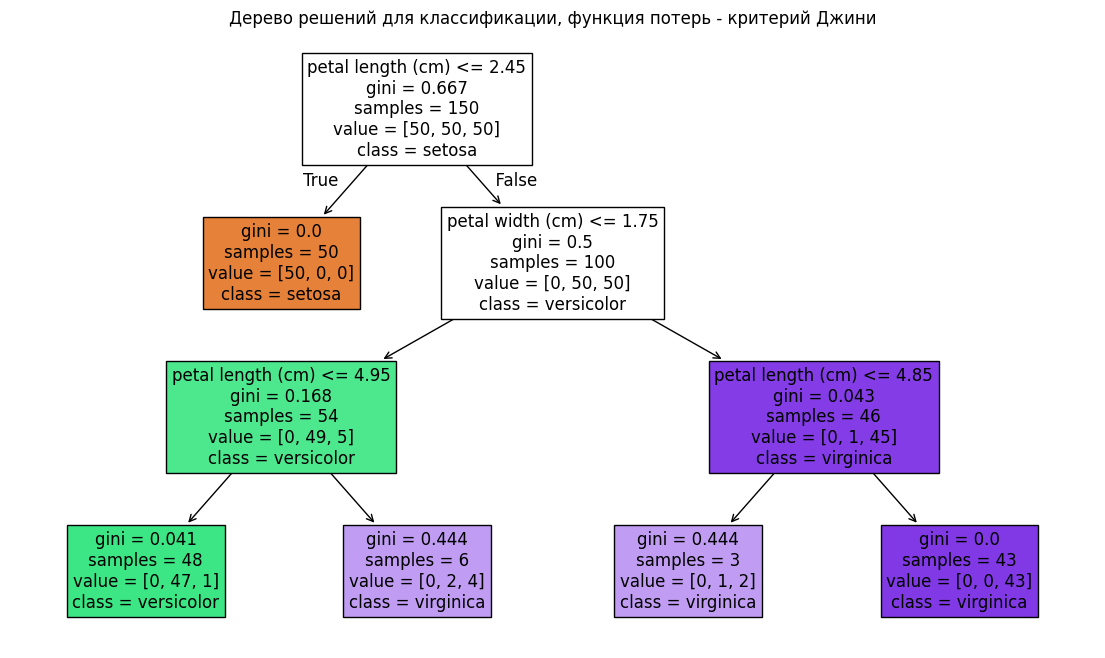

In [ ]:
# загрузим данные
data = load_iris()
X = data.data
y = data.target
feature_names = data.feature_names
class_names = data.target_names

# обучим дерево небольшой глубины, указав в качестве функции потерь критерий Джини
tree = DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=42)
tree.fit(X, y)

plt.figure(figsize=(14, 8))
plot_tree(
    tree,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    fontsize=12
)
plt.title("Дерево решений для классификации, функция потерь - критерий Джини")
plt.show()

In [ ]:
# выведем информацию о каждой из вершин в обученном дереве
tree_ = tree.tree_
for current_node in range(tree_.node_count):
    n = tree_.n_node_samples[current_node]
    impurity = tree_.impurity[current_node]
    print(f"Всего объектов в вершине: {n}")
    print(f"Критерий информативности: {impurity:.3f}")
    print()

Всего объектов в вершине: 150
Критерий информативности: 0.667

Всего объектов в вершине: 50
Критерий информативности: 0.000

Всего объектов в вершине: 100
Критерий информативности: 0.500

Всего объектов в вершине: 54
Критерий информативности: 0.168

Всего объектов в вершине: 48
Критерий информативности: 0.041

Всего объектов в вершине: 6
Критерий информативности: 0.444

Всего объектов в вершине: 46
Критерий информативности: 0.043

Всего объектов в вершине: 3
Критерий информативности: 0.444

Всего объектов в вершине: 43
Критерий информативности: 0.000



Рассмотрим вершину, в которую попало $6$ объектов и разберёмся, как считать критерий информативности.

In [ ]:
leaf_indices = tree.apply(X)

for current_node in np.unique(leaf_indices):
    objects = np.where(leaf_indices == current_node)[0]
    print("В вершину", current_node, "попали объекты", objects)
    print("Соответствующие значения y равны", np.round(y[objects], 2))
    print()

В вершину 1 попали объекты [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Соответствующие значения y равны [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]

В вершину 4 попали объекты [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  71  72  73  74  75  76  78  79  80  81  82  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 106]
Соответствующие значения y равны [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2]

В вершину 5 попали объекты [ 77  83 119 129 133 134]
Соответствующие значения y равны [1 1 2 2 2 2]

В вершину 7 попали объекты [ 70 126 138]
Соответствующие значения y равны [1 2 2]

В вершину 8 попали объекты [100 101 102 103 104 105 107 108 109 110 111 112 113 114 115 116 117 118
 120 121 122 123 124 125 127 128 130 131 1

Итак, имеем следующие значения целевой переменной в рассматриваемой вершине:
$ y = [1, 1, 2, 2, 2, 2]$, а число элементов, попавших в неё, равно $|R|=6 $

Число объектов, принадлежащих каждому из представленных в наборе данных классов:

$n_0 = 0, n_1 = 2, n_2 = 4$

Тогда вероятность каждого из классов равна:

$p_0 = \frac{0}{6} = 0, p_1 = \frac{2}{6} = \frac{1}{3}, p_2 = \frac{4}{6} = \frac{2}{3}$

Значит, критерий Джини равен:

$H(R) = 0 \cdot (1 - 0) + \frac{1}{3} \cdot (1 - \frac{1}{3}) + \frac{2}{3} \cdot (1 - \frac{2}{3}) = 2 \cdot \frac{1}{3} \cdot \frac{2}{3} = \frac{4}{9} ≈ 0.444$

### Энтропийный критерий

Другой популярный критерий информативности $-$ энтропийный критерий, который имеет вид $H(R) = -\sum_{k = 1}^{K} p_k \log p_k$.

Мы знаем, что энтропия ограничена снизу нулём, причём минимум достигается на вырожденных распределениях, а максимум $-$ на равномерном. Значит, энтропийный критерий отдаёт предпочтение более вырожденным распределениям классов в вершине, что согласуется с нашими желаниями.

Покажем, что энтропия ограничена сверху и достигает своего максимума на равномерном распределении $p_1 = \dots = p_K = 1/K$. Известно, что для любой вогнутой функции $f$ выполнено неравенство Йенсена:

$f(\sum_{i = 1}^{n} a_i x_i) \geq \sum_{i = 1}^{n} a_i f(x_i)$, если $\sum_{i = 1}^{n} a_i = 1$

Логарифм является вогнутой функцией, поэтому для него это неравенство также верно:

$H(p) = \sum_{k = 1}^{K} p_k \log_2 \frac{1}{p_k} \leq \log_2 ( \sum_{k = 1}^{K} p_i \frac{1}{p_i}) = \log_2 K$.

Энтропия равномерного распределения равна:

$-\sum_{k = 1}^{K} \frac{1}{K} \log_2 \frac{1}{K} = -K \frac{1}{K} \log_2 \frac{1}{K} = \log_2 K -$ что и требовалось доказать.

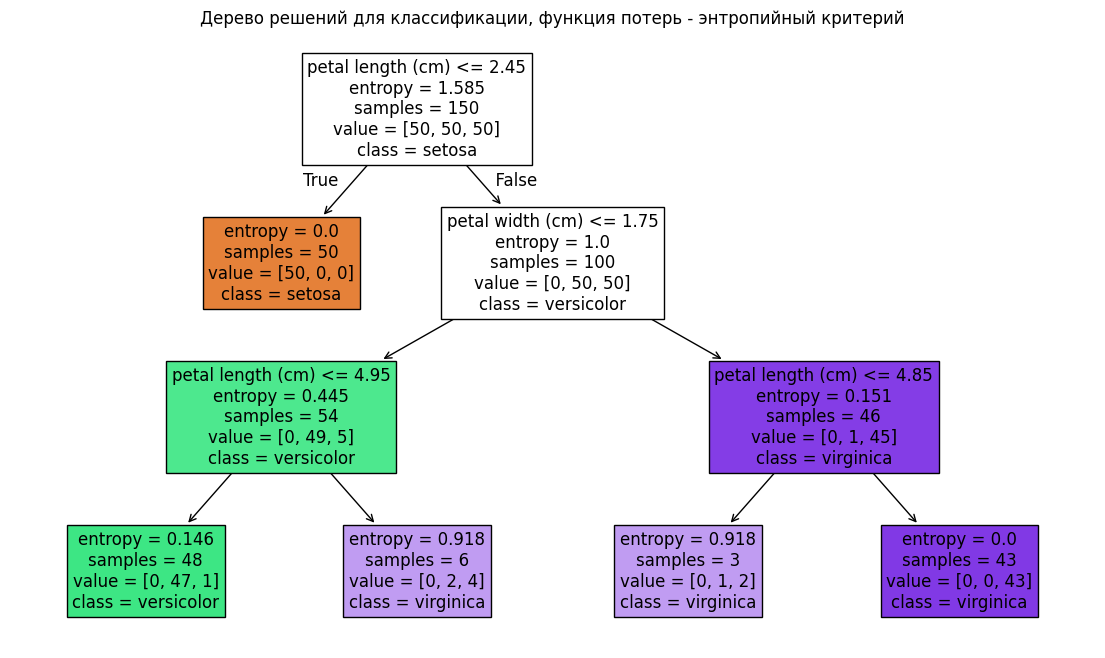

In [ ]:
# загрузим данные
data = load_iris()
X = data.data
y = data.target
feature_names = data.feature_names
class_names = data.target_names

# обучим дерево небольшой глубины, указав в качестве функции потерь энтропийный критерий
tree = DecisionTreeClassifier(max_depth=3, criterion="entropy", random_state=42)
tree.fit(X, y)

plt.figure(figsize=(14, 8))
plot_tree(
    tree,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    fontsize=12
)
plt.title("Дерево решений для классификации, функция потерь - энтропийный критерий")
plt.show()

In [ ]:
# выведем информацию о каждой из вершин в обученном дереве
tree_ = tree.tree_
for current_node in range(tree_.node_count):
    n = tree_.n_node_samples[current_node]
    impurity = tree_.impurity[current_node]
    print(f"Всего объектов в вершине: {n}")
    print(f"Критерий информативности: {impurity:.3f}")
    print()

Всего объектов в вершине: 150
Критерий информативности: 1.585

Всего объектов в вершине: 50
Критерий информативности: 0.000

Всего объектов в вершине: 100
Критерий информативности: 1.000

Всего объектов в вершине: 54
Критерий информативности: 0.445

Всего объектов в вершине: 48
Критерий информативности: 0.146

Всего объектов в вершине: 6
Критерий информативности: 0.918

Всего объектов в вершине: 46
Критерий информативности: 0.151

Всего объектов в вершине: 3
Критерий информативности: 0.918

Всего объектов в вершине: 43
Критерий информативности: 0.000



Рассмотрим вершину, в которую попало $6$ объектов и разберёмся, как считать критерий информативности.

In [ ]:
leaf_indices = tree.apply(X)

for current_node in np.unique(leaf_indices):
    objects = np.where(leaf_indices == current_node)[0]
    print("В вершину", current_node, "попали объекты", objects)
    print("Соответствующие значения y равны", np.round(y[objects], 2))
    print()

В вершину 1 попали объекты [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Соответствующие значения y равны [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]

В вершину 4 попали объекты [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  71  72  73  74  75  76  78  79  80  81  82  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 106]
Соответствующие значения y равны [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2]

В вершину 5 попали объекты [ 77  83 119 129 133 134]
Соответствующие значения y равны [1 1 2 2 2 2]

В вершину 7 попали объекты [ 70 126 138]
Соответствующие значения y равны [1 2 2]

В вершину 8 попали объекты [100 101 102 103 104 105 107 108 109 110 111 112 113 114 115 116 117 118
 120 121 122 123 124 125 127 128 130 131 1

Итак, имеем следующие значения целевой переменной в рассматриваемой вершине:
$ y = [1, 1, 2, 2, 2, 2]$, а число элементов, попавших в неё равно $|R|=6 $

Число объектов, принадлежащих каждому из представленных в наборе данных классов:

$n_0 = 0, n_1 = 2, n_2 = 4$

Тогда вероятность каждого из классов равна:

$p_0 = \frac{0}{6} = 0, p_1 = \frac{2}{6} = \frac{1}{3}, p_2 = \frac{4}{6} = \frac{2}{3}$

Значит, энтропийный критерий равен:

$H(R) = - ( p_0 \log_2 p_0 + p_1 \log_2 p_1 + p_2 \log_2 p_2) = - (\frac{1}{3}\log_2 \frac{1}{3} + \frac{2}{3}\log_2 \frac{2}{3}) ≈ - (\frac{1}{3} \cdot (-1.585) + \frac{2}{3} \cdot (-0.585)) = 0.528 + 0.390 = 0.918$

Стоит понимать, что нет никаких чётких правил выбора функционала качества и на практике, например, между критерием Джини и энтропийным критерием нет большой разницы с точки зрения получаемых результатов.

### Критерии останова

Как упоминалось ранее, деревья склонны к переобучению, поэтому очень важно выбрать правильное условие останова. К наиболее часто используемым на практике относятся:

1. Ограничение максимальной глубины дерева
2. Ограничение максимального числа листьев в дереве
3. Требование, чтобы функционал качества при делении очередной вершины на двух потомков улучшался не менее чем на $x$

Обычно используются все перечисленные ограничения, причём проверять выполнение критерия можно как во время построения дерева (такой способ имеет название *pre-pruning*), так и после построения дерева жадным алгоритмом путём удаления некоторых вершин  дерева (такой подход называется *pruning*).

Проанализируем, как отдельные гиперпараметры влияют на склонность деревьев к переобучению. Для этого сгенерируем данные и построим несколько деревьев.

In [ ]:
X, y = make_moons(n_samples=500, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

colors = ['#FF0000', '#FF7700']

x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                     np.linspace(y_min, y_max, 1000))

# функция для визуализации результатов
def draw_results(tree, X, y, ax, title):
    z = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, z, alpha=0.3, cmap=plt.cm.autumn)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=ListedColormap(colors))
    ax.set_title(title)

Сначала рассмотрим уже знакомый нам параметр $-$ максимальную глубину дерева.

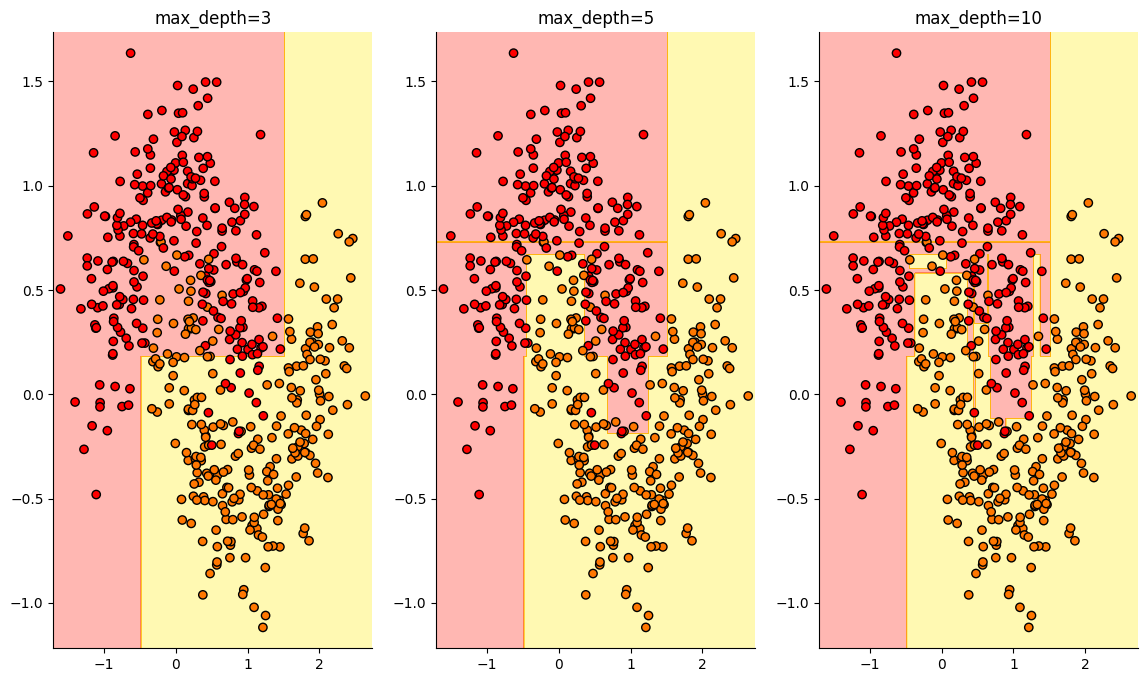

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 8))
for depth, a in zip([3, 5, 10], ax):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X, y)
    draw_results(tree, X, y, a, f'max_depth={depth}')

for ax_ in ax:
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)

plt.show()

Итак, увеличение глубины влечёт быстрое переобучение.

Теперь изучим влияние максимального числа листьев в дереве на склонность к переобучению.

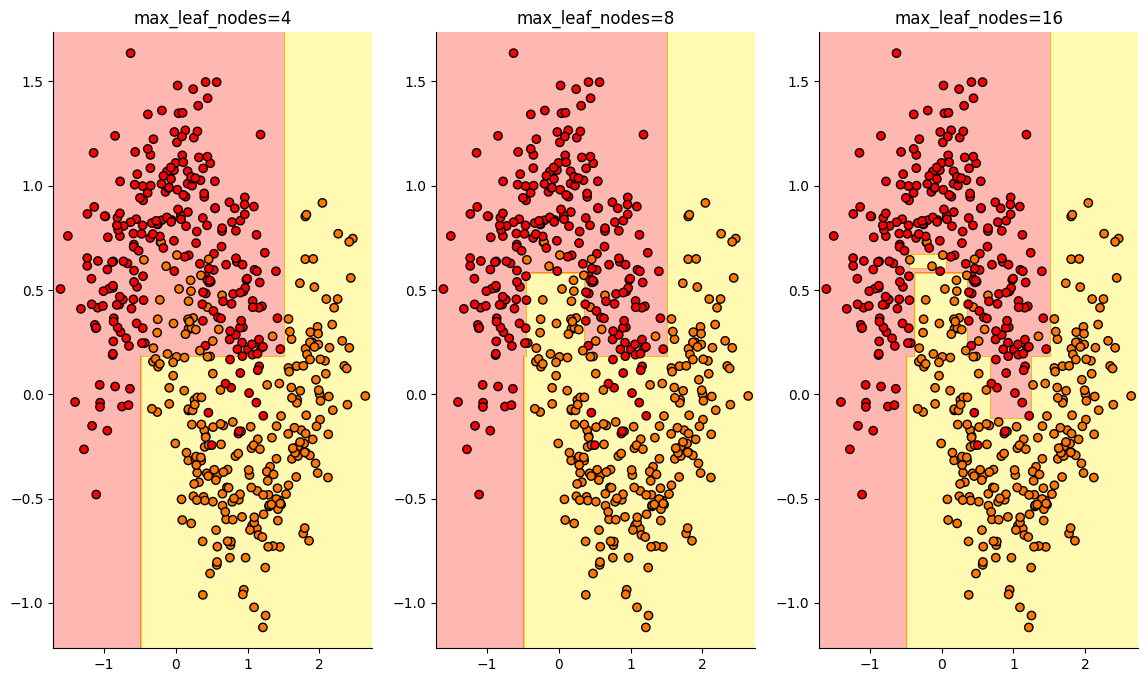

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 8))
for leaves, a in zip([4, 8, 16], ax):
    tree = DecisionTreeClassifier(max_leaf_nodes=leaves, random_state=42)
    tree.fit(X, y)
    draw_results(tree, X, y, a, f'max_leaf_nodes={leaves}')

for ax_ in ax:
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)

plt.show()

Очевидно, что увеличение числа листьев в дереве повышает риск переобучения, однако слишком малое число листьев также приводит к плачевным результатам.

Теперь рассмотрим значение, на которое должен улучшаться функционал качества на очередном шаге. Этот гиперпараметр не даёт дереву разветвляться в том случае, если прирост качества слишком мал, что предотвращает появление незначимых ветвей.

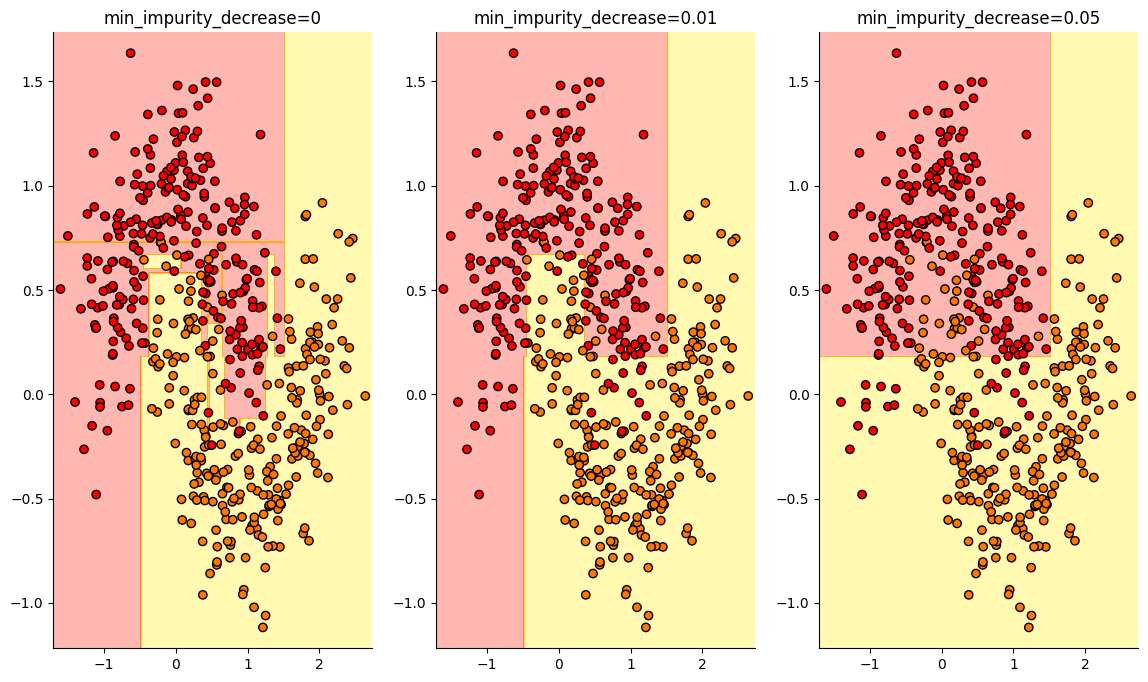

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 8))
for impurity, a in zip([0, 0.01, 0.05], ax):
    tree = DecisionTreeClassifier(min_impurity_decrease=impurity, random_state=42)
    tree.fit(X, y)
    draw_results(tree, X, y, a, f'min_impurity_decrease={impurity}')

for ax_ in ax:
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)

plt.show()

Маленькие значения гиперпараметра ведут к переобучению. Как и для других гиперпараметров, большое значение имеет баланс, так как установка слишком большого значения приведёт к тому, что дерево не обучится совсем.

Наконец, рассмотрим процесс прунинга с помощью гиперпараметра `ccp_alpha`, который определяет стоимость добавления листа в дерево. Вершины, для которых польза мала относительно заданного параметра, обрезаются.

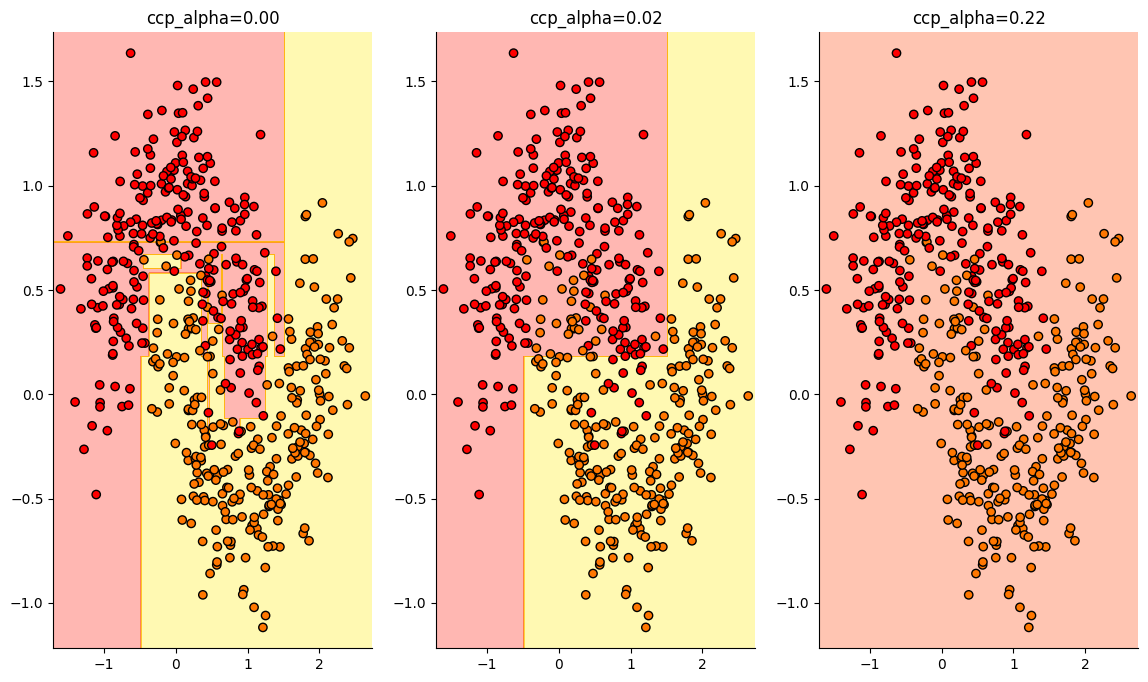

In [ ]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X, y)
ccp_path = tree.cost_complexity_pruning_path(X, y)
ccp_alphas = [np.min(ccp_path.ccp_alphas), np.mean(ccp_path.ccp_alphas), np.max(ccp_path.ccp_alphas)]

fig, ax = plt.subplots(1, 3, figsize=(14, 8))
for alpha, a in zip(ccp_alphas, ax):
    tree = DecisionTreeClassifier(ccp_alpha=alpha, random_state=42)
    tree.fit(X, y)
    draw_results(tree, X, y, a, f'ccp_alpha={alpha:.2f}')

for ax_ in ax:
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)

plt.show()

Итак, маленькое значение $\alpha$ значительно повышает риск переобучения, так как дерево строится практически без ограничений. С ростом $\alpha$ дерево обрезается всё сильнее, становится проще и лучше обобщается на новые данные, однако при слишком больших значениях модель становится излишне простой, и качество резко падает.

## Преимущества и недостатки решающих деревьев

В заключение обсудим преимущества и недостатки решающих деревьев.

Неоспоримыми преимуществами являются:

1. Простота и интерпретируемость
2. Отсутствие чувствительности к масштабам признаков, благодаря чему нет необходимости в нормализации
3. Возможность работы как с числовыми, так и с категориальными признаками без дополнительной обработки
4. Возможность обработки пропущенных значений (например, в случае отсутствия значения некоторого признака для объекта, его можно направить в оба поддерева, а затем в зависимости от решаемой задачи получить финальный ответ на основании всех листов, в которые объект попал)

При этом решающие деревья обладают рядом серьёзных недостатков:

1. Склонность к переобучению
2. Ограниченная способность к аппроксимации сложных зависимостей
3. Нестабильность

Последний пункт означает, что даже малые изменения в данных могут привести к значительным изменениям структуры дерева, что делает модель очень чувствительной к шуму. Для демонстрации этого посмотрим, как будет меняться структура дерева при обучении на разных подвыборках, составляющих $90\%$ от всех имеющихся данных.

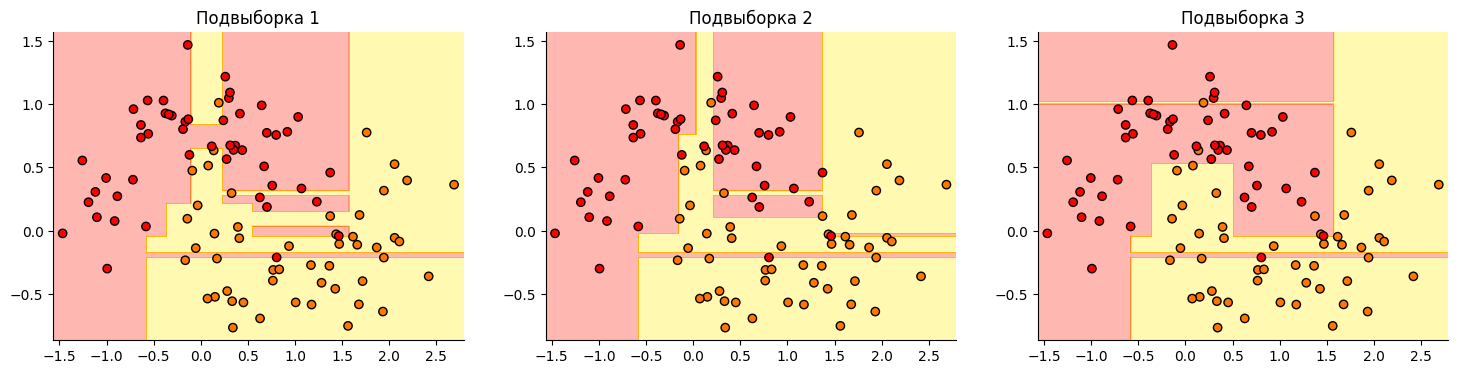

In [ ]:
X, y = make_moons(n_samples=100, noise=0.25, random_state=42)

x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                     np.linspace(y_min, y_max, 1000))
z_points = np.c_[xx.ravel(), yy.ravel()]

plt.figure(figsize=(18, 4))
n = X.shape[0]

colors = ['#FF0000', '#FF7700']

# будем создавать три подвыборки, каждая из которых содержит 90% данных
for i in range(3):
    X_sample, _, y_sample, _ = train_test_split(X, y, train_size=0.9, random_state=i*42)
    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_sample, y_sample)

    z = tree.predict(z_points).reshape(xx.shape)

    plt.subplot(1, 3, i + 1)
    plt.contourf(xx, yy, z, alpha=0.3, cmap=plt.cm.autumn)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=ListedColormap(colors))
    plt.title(f"Подвыборка {i+1}")

    for ax in plt.gcf().get_axes():
          ax.spines['top'].set_visible(False)
          ax.spines['right'].set_visible(False)

plt.show()

## Дополнительные материалы

Замечательная иллюстрация работы решающих деревьев представлена по [ссылке](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/).